In [96]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,TimeSeriesSplit

#parse dates making the dates in column 0 from string to datetime object
data = pd.read_csv("/home/noam/Desktop/Noam/Python/stockApp/stocks_csvs/msft.csv")
data['Date'] = data['Date'].to_numpy().astype('datetime64')
#making new column for each day verses the date
data["Day In Week"] = data['Date'].dt.day_name()

/tmp/ipykernel_2515672/207051339.py:17: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  data['Date'] = data['Date'].to_numpy().astype('datetime64')


In [97]:
def calcol_percentage(close,open):
    num = (close - open) / open
    return num
def calcol_neg_per(close,open):
    if(close - open < 0):
         return True
    else:
         return False
data['Movement%'] = np.vectorize(calcol_percentage)(data['Close'],data['Open'])
# data['is_neg_movement%'] = np.vectorize(calcol_neg_per)(data['Close'],data['Open'])

In [98]:
df_fordays = pd.DataFrame(data['Day In Week'])
days_df = df_fordays.select_dtypes(include='object')
rest_of_df = data.drop('Day In Week',axis=1)
df_objects_dummies = pd.get_dummies(days_df)
final_df= pd.concat([rest_of_df,df_objects_dummies],axis=1)
data = final_df
#knowing corr between movement to the other columns
data = data.drop('Dividends',axis=1)
data['Day In Week'] = data['Date'].dt.day_name()

In [99]:
data['Date'] = data['Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d').astype('datetime64[ns]')
data = data.set_index('Date')
df = data[['Close']]

In [100]:
friday_df = data[data["Day In Week_Friday"] == True]
friday_df = friday_df[['Close']]

In [101]:
def window_data(data,start_date,end_date, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Close'].shift(i)
    windowed_data['Target'] = data['Close']
    windowed_data = windowed_data.loc[start_date:end_date]
    windowed_data = windowed_data.reset_index()
    windowed_data.rename(columns = {'Date':'Target Date'}, inplace = True)
    return windowed_data.dropna()


In [102]:
#data=df or data=friday_df
windowed_df = window_data(df, '2020-05-02', '2023-06-09', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-05-04,172.156982,173.884064,169.382004,173.525085
1,2020-05-05,173.884064,169.382004,173.525085,175.388000
2,2020-05-06,169.382004,173.525085,175.388000,177.115112
3,2020-05-07,173.525085,175.388000,177.115112,178.143646
4,2020-05-08,175.388000,177.115112,178.143646,179.191544
...,...,...,...,...,...
777,2023-06-05,328.390015,332.579987,335.399994,335.940002
778,2023-06-06,332.579987,335.399994,335.940002,333.679993
779,2023-06-07,335.399994,335.940002,333.679993,323.380005
780,2023-06-08,335.940002,333.679993,323.380005,325.260010


In [103]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((782,), (782, 3, 1), (782,))

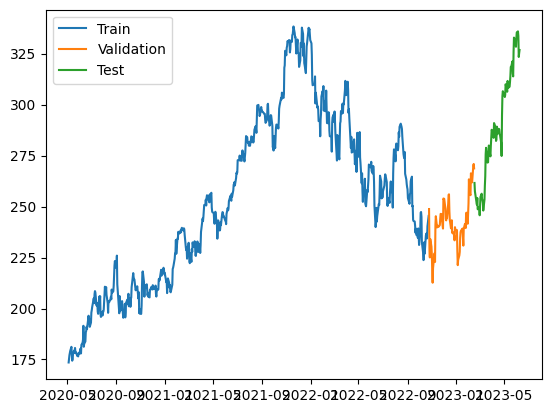

In [104]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [105]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100


2023-06-13 16:47:37.715688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 16:47:37.716581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 16:47:37.717242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 1s 14ms/step - loss: 65469.2734 - mean_absolute_error: 252.4478 - val_loss: 58296.8828 - val_mean_absolute_error: 241.1294
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 64945.5352 - mean_absolute_error: 251.4085 - val_loss: 57769.3281 - val_mean_absolute_error: 240.0330
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 68467.0156 - mean_absolute_error: 259.0141

2023-06-13 16:47:38.990850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 16:47:38.992458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 16:47:38.993542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 0s 3ms/step - loss: 64159.6094 - mean_absolute_error: 249.8340 - val_loss: 56554.7773 - val_mean_absolute_error: 237.4887
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 61958.8945 - mean_absolute_error: 245.3631 - val_loss: 53133.8672 - val_mean_absolute_error: 230.1740
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 57280.8906 - mean_absolute_error: 235.6431 - val_loss: 47546.4102 - val_mean_absolute_error: 217.6967
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 49914.7344 - mean_absolute_error: 219.3615 - val_loss: 38927.7383 - val_mean_absolute_error: 196.9105
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 39557.5117 - mean_absolute_error: 194.2312 - val_loss: 27793.4844 - val_mean_absolute_error: 166.2516
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 27522.8008 - mean_absolute_error: 160.2059 - val_loss: 16539.093

20/20 [==============================] - 0s 917us/step


2023-06-13 16:47:45.224735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 16:47:45.225773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 16:47:45.226415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

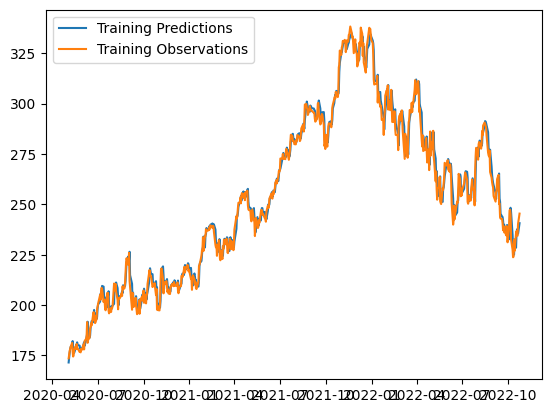

In [106]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 1ms/step


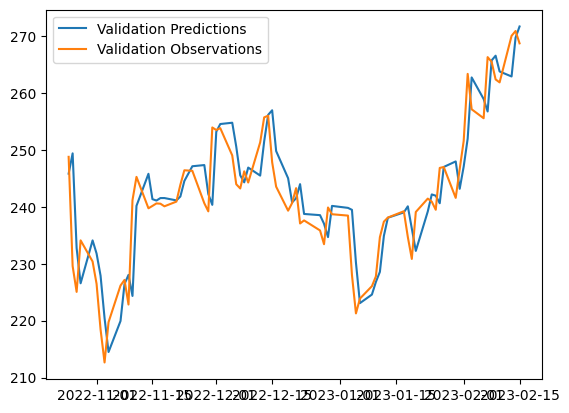

In [107]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 1ms/step


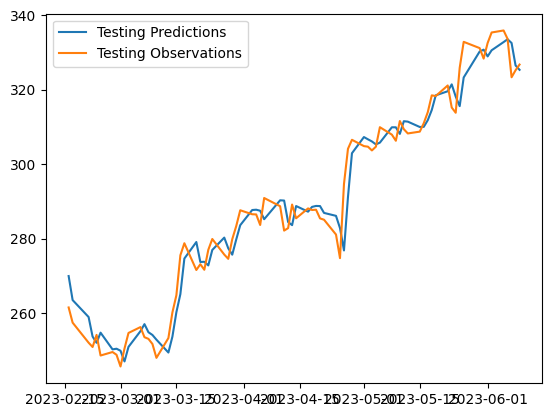

In [108]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

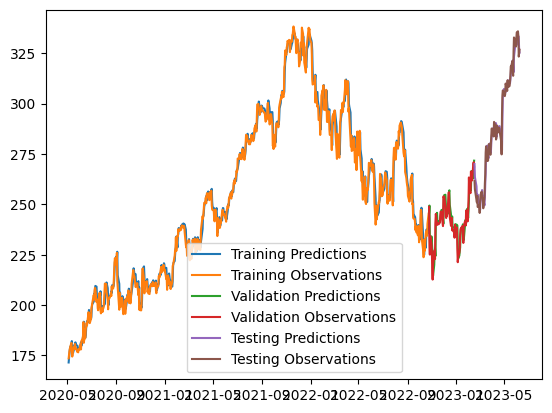

In [109]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [110]:
from copy import deepcopy

predictions_values = []
predict_days = []
new_array_values = []
tst = np.array([[y_test[-3]],[y_test[-2]],[y_test[-1]]])
#X_test[-1]
predictions_array_for_predict = [deepcopy(X_test[-1])]
for i in range(1,2):
    predict_days.append(dates_test[-1] + dt.timedelta(days=i))
    next_prediction = model.predict(np.array(predictions_array_for_predict))
    predictions_values.append(next_prediction)
    predictions_array_for_predict[0][-3] = predictions_array_for_predict[0][-2]
    predictions_array_for_predict[0][-2] = predictions_array_for_predict[0][-1]
    predictions_array_for_predict[0][-1] = [next_prediction]
for i in range(0,1):
    new_array_values.append(predictions_values[i][0][0])
print(f'the next value of the stock is: {new_array_values[0]}')


1/1 [==============================] - 0s 11ms/step
the next value of the stock is: 325.3721923828125


/tmp/ipykernel_2515672/292774499.py:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  predictions_array_for_predict[0][-1] = [next_prediction]


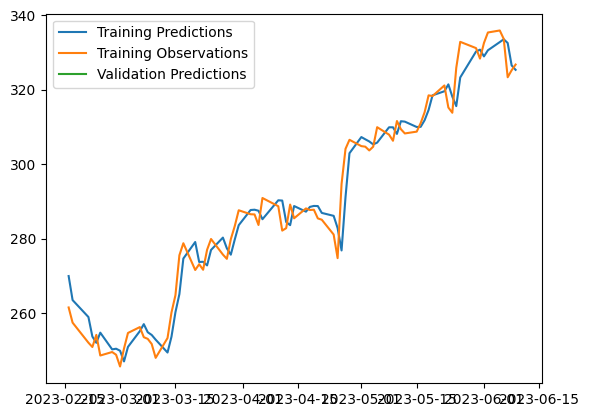

In [111]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
# plt.plot(dates_val, val_predictions)
# plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(predict_days, new_array_values)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [112]:
test_predictions[-10:-1]

array([323.32123, 330.28644, 330.79187, 328.9787 , 330.62436, 332.82422,
       333.57822, 332.58224, 326.5551 ], dtype=float32)

In [113]:
y_test[-10:-1]

array([332.89, 331.21, 328.39, 332.58, 335.4 , 335.94, 333.68, 323.38,
       325.26], dtype=float32)